# Document Similarity - w/ AttentionMM (doc similarity)

In [1]:
from __future__ import division, print_function
from keras import backend as K
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import custom_attn
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

DOCSIM_IDLABELS = os.path.join(DATA_DIR, "docsim-idlabels.tsv")
DOCSIM_TEXTS = os.path.join(DATA_DIR, "docsim-texts.tsv")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 2

BATCH_SIZE = 64
NUM_EPOCHS = 5

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [6]:
docid2mat = {}
ftext = open(DOCSIM_TEXTS, "rb")
for line in ftext:
    rec_id, text = line.strip().split("\t")
    M = np.zeros((MAX_SENTS, MAX_WORDS))
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = pad_or_truncate(nltk.word_tokenize(sent), MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            M[sid, wid] = word_id
    docid2mat[int(rec_id)] = M
ftext.close()
print(len(docid2mat), docid2mat[list(docid2mat.keys())[0]].shape)

1885 (40, 60)


## Extract Label and DocID pairs

In [7]:
xdata, ydata = [], []
fidl = open(DOCSIM_IDLABELS, "rb")
for line in fidl:
    label, docid_left, docid_right = line.strip().split("\t")
    xdata.append((int(docid_left), int(docid_right)))
    ydata.append(int(label))
X = np.array(xdata)
Y = to_categorical(np.array(ydata), num_classes=NUM_CLASSES)
print(X.shape, Y.shape)

(70253, 2) (70253, 2)


## Partition into training, validation and test

In [8]:
Xtv, Xtest, Ytv, Ytest = train_test_split(X, Y, train_size=0.7)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtv, Ytv, train_size=0.9)
print(Xtrain.shape, Ytrain.shape, Xval.shape, Yval.shape, 
      Xtest.shape, Ytest.shape)

(44259, 2) (44259, 2) (4918, 2) (4918, 2) (21076, 2) (21076, 2)


## Build Data Generator

In [9]:
def datagen(X, Y, docid2mat, batch_size=BATCH_SIZE):
    while True:
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            batch_ids = indices[bid * batch_size : (bid + 1) * batch_size]
            Xbatch_l = np.zeros((batch_size, MAX_SENTS, MAX_WORDS))
            Xbatch_r = np.zeros((batch_size, MAX_SENTS, MAX_WORDS))
            for idx, (docid_l, docid_r) in enumerate(X[batch_ids, :]):
                Xbatch_l[idx] = docid2mat[docid_l]
                Xbatch_r[idx] = docid2mat[docid_r]
            Ybatch = Y[batch_ids, :]
            yield [Xbatch_l, Xbatch_r], Ybatch

train_gen = datagen(Xtrain, Ytrain, docid2mat)
[Xbatch_left, Xbatch_right], Ybatch = train_gen.next()
print(Xbatch_left.shape, Xbatch_right.shape, Ybatch.shape)

(64, 40, 60) (64, 40, 60) (64, 2)


## Define Network

### Sentence Networks

In [10]:
sent_in = Input(shape=(MAX_WORDS,), dtype="int32")

sent_emb = Embedding(input_dim=vocab_size,
                       output_dim=WORD_EMBED_SIZE,
                       weights=[E])(sent_in)

sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                               return_sequences=False))(sent_emb)

sent_model = Model(inputs=sent_in, outputs=sent_enc)
sent_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 60, 300)           12219000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240600    
Total params: 12,459,600
Trainable params: 12,459,600
Non-trainable params: 0
_________________________________________________________________


### Document Networks

In [11]:
def sum_over_axis(X, axis):
    return K.mean(X, axis=axis)

In [12]:
# LHS document
doc_in_l = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb_l = TimeDistributed(sent_model)(doc_in_l)

doc_enc_l = Bidirectional(GRU(DOC_EMBED_SIZE,
                              return_sequences=True))(doc_emb_l)

# RHS document
doc_in_r = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb_r = TimeDistributed(sent_model)(doc_in_r)

doc_enc_r = Bidirectional(GRU(DOC_EMBED_SIZE,
                              return_sequences=True))(doc_emb_r)

# Attention
doc_att = custom_attn.AttentionMM("concat")([doc_enc_l, doc_enc_r])
doc_att = BatchNormalization()(doc_att)

# Prediction
fc1_dropout = Dropout(0.2)(doc_att)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
doc_pred = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=[doc_in_l, doc_in_r], outputs=doc_pred)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 40, 60)        0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 40, 60)        0                                            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, 40, 200)       12459600    input_2[0][0]                    
____________________________________________________________________________________________________
time_distributed_2 (TimeDistribu (None, 40, 200)       12459600    input_3[0][0]                    
___________________________________________________________________________________________

## Train Network

In [13]:
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [14]:
train_gen = datagen(Xtrain, Ytrain, docid2mat, batch_size=BATCH_SIZE)
val_gen = datagen(Xval, Yval, docid2mat, batch_size=BATCH_SIZE)

num_train_steps = len(Xtrain) // BATCH_SIZE
num_val_steps = len(Xval) // BATCH_SIZE

history = model.fit_generator(train_gen, 
                              steps_per_epoch=num_train_steps,
                              epochs=NUM_EPOCHS,
                              validation_data=val_gen,
                              validation_steps=num_val_steps)

Epoch 1/5
691/691 [==============================] - 944s - loss: 0.1604 - acc: 0.9233 - val_loss: 0.0829 - val_acc: 0.9788
Epoch 2/5
691/691 [==============================] - 939s - loss: 0.0412 - acc: 0.9891 - val_loss: 0.0565 - val_acc: 0.9846
Epoch 3/5
691/691 [==============================] - 939s - loss: 0.0363 - acc: 0.9909 - val_loss: 0.1127 - val_acc: 0.9648
Epoch 4/5
691/691 [==============================] - 939s - loss: 0.0328 - acc: 0.9915 - val_loss: 0.0424 - val_acc: 0.9885
Epoch 5/5
691/691 [==============================] - 939s - loss: 0.0292 - acc: 0.9927 - val_loss: 0.0504 - val_acc: 0.9860


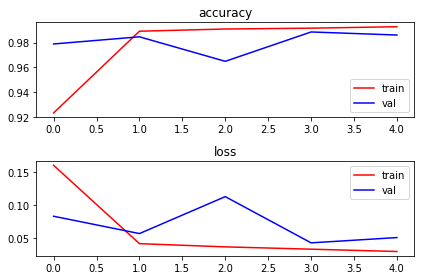

In [15]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [16]:
np.set_printoptions(linewidth=120)
test_gen = datagen(Xtest, Ytest, docid2mat, batch_size=BATCH_SIZE)
num_test_steps = len(Xtest) // BATCH_SIZE

Ytest_ = model.predict_generator(test_gen, num_test_steps)

ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)[0:len(ytest_)]

print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.498

confusion matrix

[[5424 5230]
 [5348 5054]]
